# Spotify Music Genre Analysis

## Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
import string, unicodedata

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

%matplotlib inline
sns.set(style="ticks", context="notebook")
plt.style.use("dark_background")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spotify-tracks-genre-dataset/train.csv


In [2]:
# reading data
path = '../input/spotify-tracks-genre-dataset/train.csv'

original_df = pd.read_csv(path)
df = original_df.copy()

## Data Inspection

In [3]:
print(df.shape)
df.head()

(114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [5]:
df.nunique()

Unnamed: 0          114000
track_id             89741
artists              31437
album_name           46589
track_name           73608
popularity             101
duration_ms          50697
explicit                 2
danceability          1174
energy                2083
key                     12
loudness             19480
mode                     2
speechiness           1489
acousticness          5061
instrumentalness      5346
liveness              1722
valence               1790
tempo                45653
time_signature           5
track_genre            114
dtype: int64

In [6]:
df.duplicated().value_counts()

False    114000
Name: count, dtype: int64

In [7]:
df.isnull().any()

Unnamed: 0          False
track_id            False
artists              True
album_name           True
track_name           True
popularity          False
duration_ms         False
explicit            False
danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
time_signature      False
track_genre         False
dtype: bool

In [8]:
df[df["artists"].isna()==True]

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,...,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


In [9]:
df[df["album_name"].isna()==True]

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,...,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


In [10]:
df[df["track_name"].isna()==True]

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,...,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


In [11]:
df.fillna('',inplace=True)

In [12]:
df[df.index == 65900]

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,65900,1kR4gIb7nGxHPI3D2ifs59,,,,0,0,False,0.501,0.583,...,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


In [13]:
df.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [14]:
print(df.dtypes[df.dtypes != "object"].index)
len(df.dtypes[df.dtypes != "object"].index)

Index(['Unnamed: 0', 'popularity', 'duration_ms', 'explicit', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')


16

In [15]:
artists_counts = df['artists'].value_counts()
most_frequent_artists = artists_counts.idxmax()
most_frequent_artists_count = artists_counts.max()
print(f"The artist with the most tracks is '{most_frequent_artists}' with {most_frequent_artists_count} tracks.")

The artist with the most tracks is 'The Beatles' with 279 tracks.


## Data Visualization

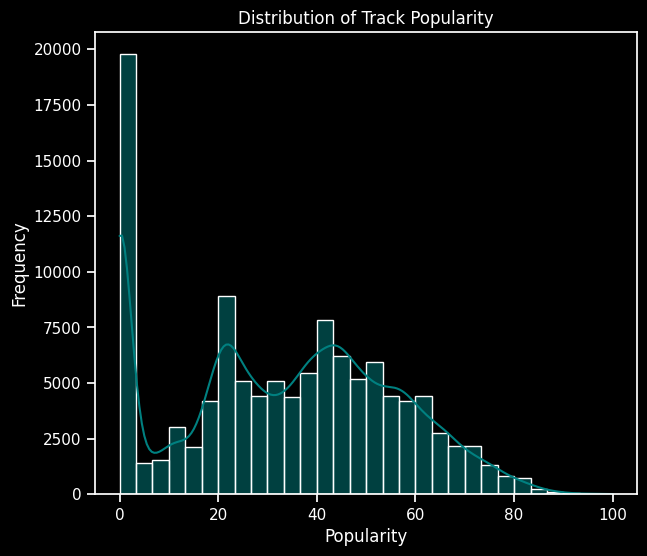

In [16]:
plt.figure(figsize=(7, 6))
sns.histplot(df['popularity'], bins=30, kde=True, color='#008080')
plt.title('Distribution of Track Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

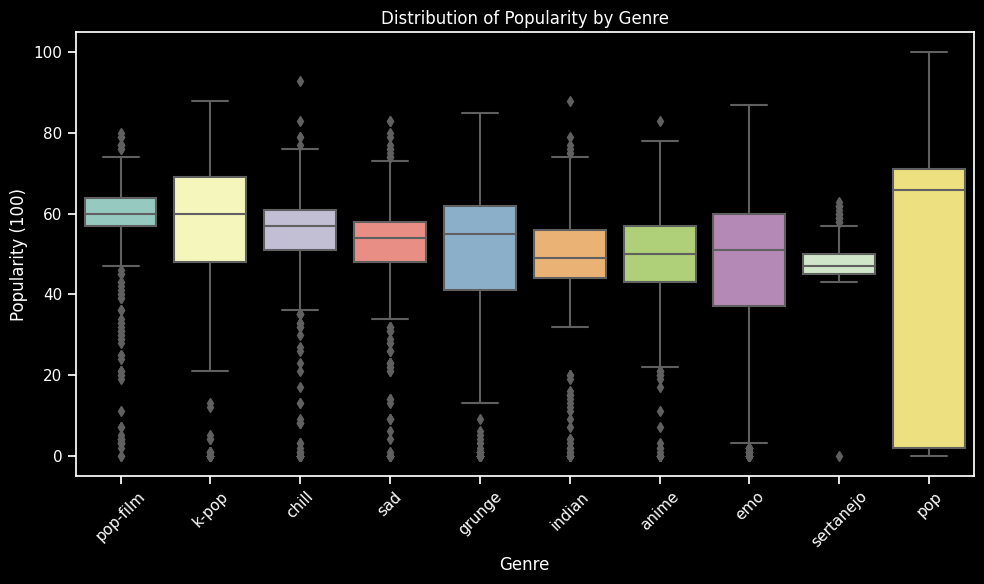

In [17]:
top_genres = df.groupby("track_genre")["popularity"].mean().sort_values(ascending=False).head(10).index
Spotify_top_genres = df[df['track_genre'].isin(top_genres)]

plt.figure(figsize=(10, 6))

sns.boxplot(x='track_genre', y='popularity', data=Spotify_top_genres, order=top_genres)
plt.title('Distribution of Popularity by Genre')
plt.xlabel('Genre')
plt.ylabel('Popularity (100)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Clustering Attributes

In [18]:
df['clustering_attributes'] = (df['artists'] + ' ' + 
                               df['track_name'] + ' ' + 
                                df['track_genre'])

In [19]:
df

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,clustering_attributes
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,Gen Hoshino Comedy acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,Ben Woodward Ghost - Acoustic acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,Ingrid Michaelson;ZAYN To Begin Again acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,Kina Grannis Can't Help Falling In Love acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,Chord Overstreet Hold On acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music,Rainy Lullaby Sleep My Little Boy world-music
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music,Rainy Lullaby Water Into Light world-music
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music,Cesária Evora Miss Perfumado world-music
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music,Michael W. Smith Friends world-music


## Data Cleaning

In [20]:
# function to remove punctuations
def remove_punctuation(text):
    '''a function for removing punctuation'''
    translator = str.maketrans(string.punctuation, " "*len(string.punctuation))
    # return the text stripped of punctuation marks
    return text.translate(translator)

df['clustering_attributes'] = df['clustering_attributes'].apply(remove_punctuation)

In [21]:
df

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,clustering_attributes
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,Gen Hoshino Comedy acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,Ben Woodward Ghost Acoustic acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,Ingrid Michaelson ZAYN To Begin Again acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,Kina Grannis Can t Help Falling In Love acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,Chord Overstreet Hold On acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music,Rainy Lullaby Sleep My Little Boy world music
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music,Rainy Lullaby Water Into Light world music
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music,Cesária Evora Miss Perfumado world music
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music,Michael W Smith Friends world music


In [22]:
def remove_non_ascii(words):
    """Function to remove non-ASCII characters"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

df['clustering_attributes'] = remove_non_ascii(df['clustering_attributes'])

In [23]:
# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all',
       'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at',
       'be', 'because', 'been', 'before', 'being', 'below', 'between',
       'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did',
       'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don',
       "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further',
       'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven',
       "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers',
       'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd",
       'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it',
       "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll',
       'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn',
       "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not',
       'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'ot

In [24]:
# function to remove stop words
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

# Removing stop words
df['clustering_attributes'] = df['clustering_attributes'].apply(stopwords)

In [25]:
df['clustering_attributes'].duplicated().value_counts()

clustering_attributes
False    96777
True     17223
Name: count, dtype: int64

In [26]:
df = df.sort_values('popularity', ascending=False).drop_duplicates('clustering_attributes').sort_index()

In [27]:
tokenizer = TweetTokenizer()
df['clustering_attributes'] = df['clustering_attributes'].apply(lambda x: tokenizer.tokenize(x))

In [28]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

df['clustering_attributes'] = df['clustering_attributes'].apply(lemmatize_verbs)

In [29]:
df

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,clustering_attributes
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,"[gen, hoshino, comedy, acoustic]"
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,"[ben, woodward, ghost, acoustic, acoustic]"
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,"[ingrid, michaelson, zayn, begin, acoustic]"
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,"[kina, grannis, help, fall, love, acoustic]"
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,"[chord, overstreet, hold, acoustic]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music,"[rainy, lullaby, sleep, little, boy, world, mu..."
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music,"[rainy, lullaby, water, light, world, music]"
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music,"[cesaria, evora, miss, perfumado, world, music]"
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music,"[michael, w, smith, friends, world, music]"


## K-Means Clustering

In [30]:
clustering_data = df['clustering_attributes']

def identity_tokenizer(text):
    return text

# Using TFIDF vectorizer to vectorize the corpus 
# max features = 20000 to prevent system from crashing
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False,max_features = 800)    
X = tfidf.fit_transform(clustering_data)

print(X.shape)
X

(96777, 800)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 288243 stored elements and shape (96777, 800)>

In [31]:
X = X.toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(0, 0.5, 'cumulative explained variance')

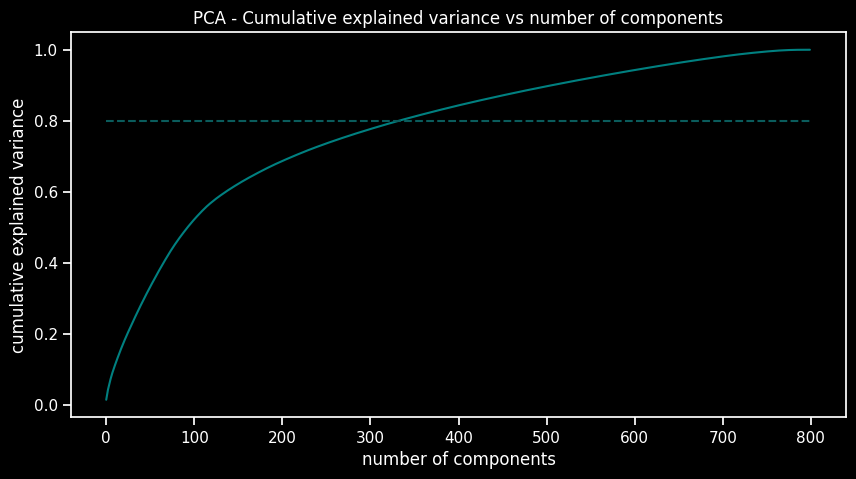

In [32]:
pca = PCA(random_state=42)
pca.fit(X)

# Explained variance for different number of components
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='#008080')
plt.hlines(y=0.8, xmin=0, xmax=800,color='#0a5c5c', linestyles='--')
plt.title('PCA - Cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [33]:
# reducing the dimensions to 350 using pca
pca = PCA(n_components=350,random_state=42)
pca.fit(X)
x_pca = pca.transform(X)

Text(0, 0.5, 'WCSS')

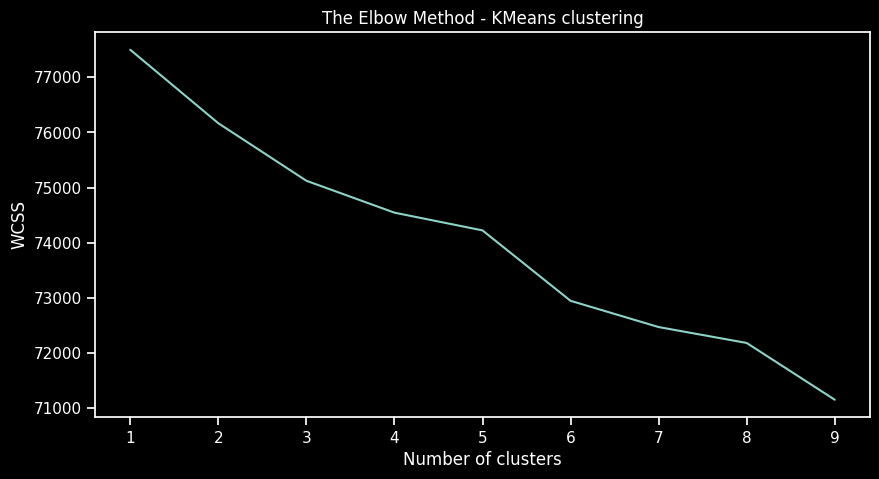

In [34]:
# Elbow method to find the optimal value of k
wcss=[]
for i in range(1,10):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.figure(figsize=(10,5))
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method - KMeans clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

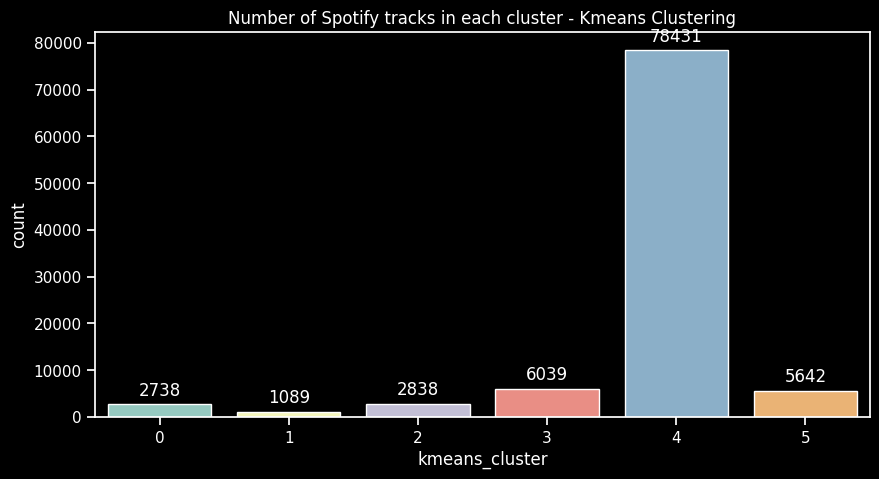

In [35]:
kmeans = KMeans(n_clusters=6,init='k-means++',random_state=33)
kmeans.fit(x_pca)

# kmeans_distortion = kmeans.inertia_
# kmeans_silhouette_score = silhouette_score(x_pca, kmeans.labels_)

# print((kmeans_distortion,kmeans_silhouette_score))

# Adding a kmeans cluster number attribute
df['kmeans_cluster'] = kmeans.labels_

# Number of Spotify tracks in each cluster
plt.figure(figsize=(10,5))
q = sns.countplot(x='kmeans_cluster',data=df)
plt.title('Number of Spotify tracks in each cluster - Kmeans Clustering')
for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

## Word Cloud

In [36]:
def kmeans_wordcloud(cluster_num):
    comment_words = ''
    stopwords = set(STOPWORDS)
    
    # iterate through the csv file
    for val in df[df['kmeans_cluster']==cluster_num].track_genre.values:
      
      # typecaste each val to string
      val = str(val)
    
      # split the value
      tokens = val.split()
      
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      
      comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)

    # plot the WordCloud image                      
    plt.figure(figsize = (10,5), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

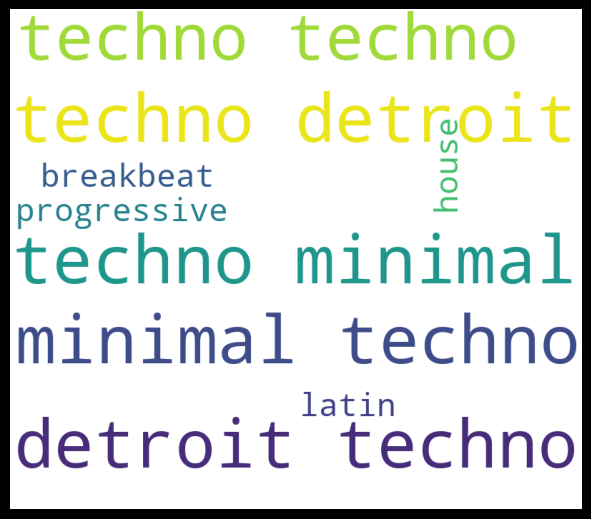

In [37]:
kmeans_wordcloud(0)

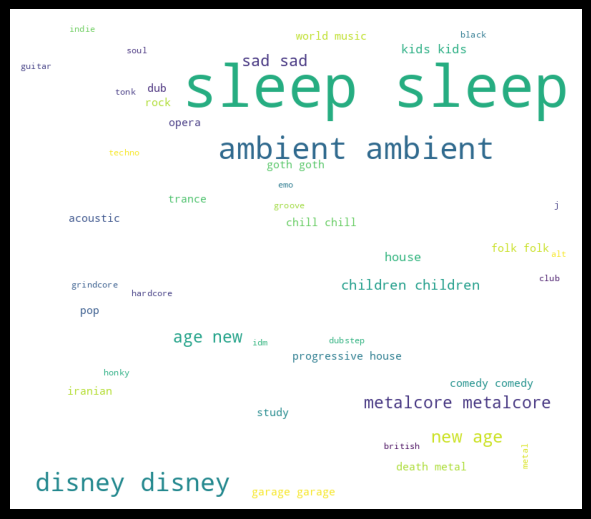

In [38]:
kmeans_wordcloud(1)

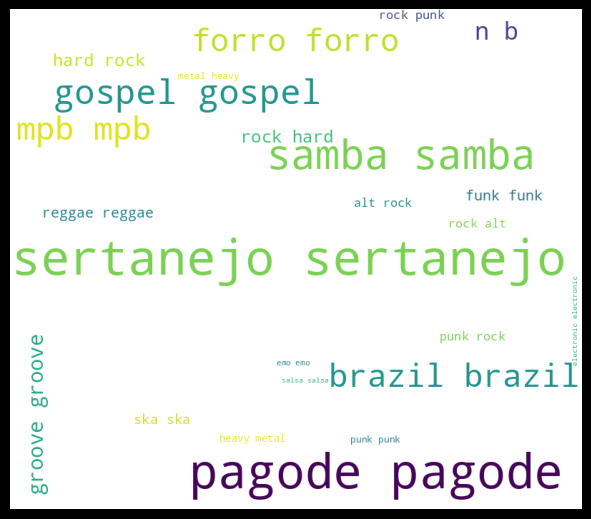

In [39]:
kmeans_wordcloud(2)

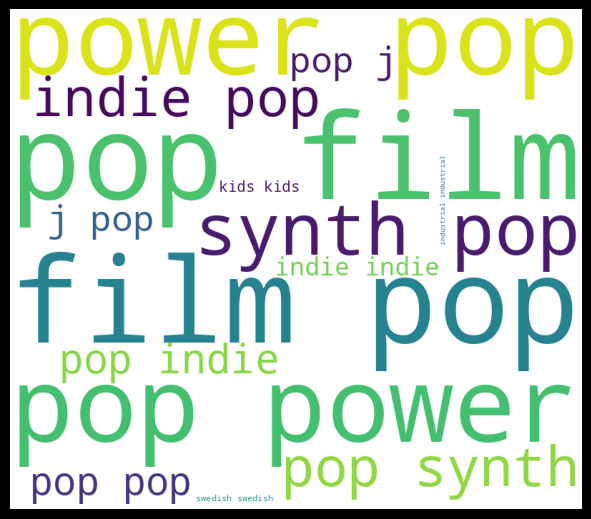

In [40]:
kmeans_wordcloud(3)

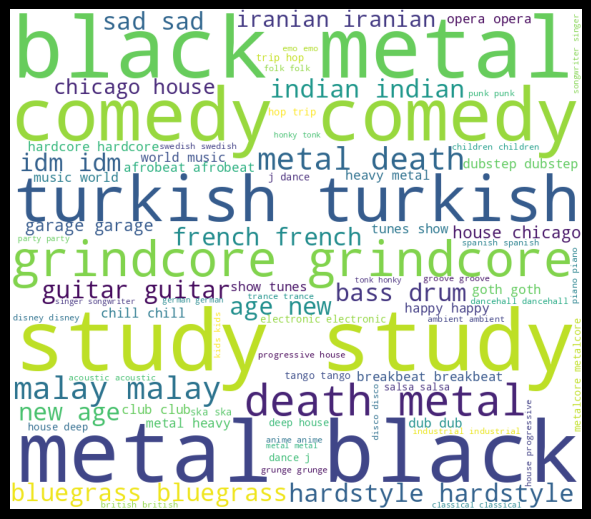

In [41]:
kmeans_wordcloud(4)

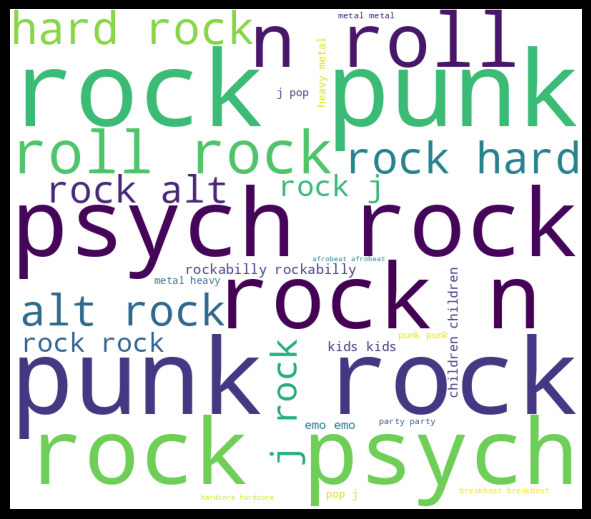

In [42]:
kmeans_wordcloud(5)